## パッケージのインポート

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

## データセットを読み込みと正規化

In [2]:
path = 'data/datasets'

mnist_train = MNIST(path, train=True, download=True, transform=None)
train_x = mnist_train.data
train_y = mnist_train.targets

mnist_test = MNIST(path, train=False, download=True, transform=None)
test_x = mnist_test.data
test_y = mnist_test.targets

train_x = train_x / 255
test_x = test_x / 255

train_x = train_x.reshape(60000, 1, 28, 28)
test_x = test_x.reshape(10000, 1, 28, 28)



In [3]:
noise_mnist_train = MNIST(path, train=True, download=True, transform=None)
train_x_noise = mnist_train.data

noise_mnist_test = MNIST(path, train=False, download=True, transform=None)
test_x_noise = mnist_test.data

train_x_noise = train_x_noise / 255
test_x_noise = test_x_noise / 255

train_x_noise = train_x_noise.reshape(60000, 1, 28, 28)
test_x_noise = test_x_noise.reshape(10000, 1, 28, 28)

## ノイズの生成

In [4]:
noise = 50

for i in range(len(train_x_noise)):
    temp_img = train_x_noise[i]
    for j in range(noise):
        x_rand = np.random.randint(28)
        y_rand = np.random.randint(28)
        temp_img[0, x_rand, y_rand] = np.random.rand()
    train_x_noise[i] = temp_img

In [5]:
for i in range(len(test_x_noise)):
    temp_img = test_x_noise[i]
    for j in range(noise):
        x_rand = np.random.randint(28)
        y_rand = np.random.randint(28)
        temp_img[0, x_rand, y_rand] = np.random.rand()
    test_x_noise[i] = temp_img

## データセットの確認

In [6]:
print('+++ MNIST data +++')
print(train_x.shape)
print(test_x.shape)

print('+++ MNIST label +++')
print(train_y.shape)
print(test_y.shape)


+++ MNIST data +++
torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
+++ MNIST label +++
torch.Size([60000])
torch.Size([10000])


## 学習用データセットとテスト用データセットを作成

In [7]:
train_dataset = TensorDataset(train_x_noise, train_x)  # 第一引数：入力画像、第二引数：正解画像
test_dataset = TensorDataset(test_x_noise, test_x)

## バッチサイズ分ずつデータを読み出すData Loaderを作成

In [8]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1)

## ネットワークの構築

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 4, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(4, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(16, 1, kernel_size=3, padding='same'),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

## CPUを使うのかGPUを使うのかを指定と確認

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

print("Device: {}".format(device))

Device: cuda


## 損失関数と最適化関数の定義

In [11]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

## ネットワークの構造の確認

In [12]:
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Sigmoid()
  )
)


## ニューラルネットを学習モードに設定

In [13]:
net.train()

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Sigmoid()
  )
)

## loss(損失)とaccuracy(正解率)を保存するための空リストを作成

In [14]:
train_loss_list = []

## 学習

In [15]:
epoch = 10

for i in range(epoch):
    print('-------------------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    train_loss = 0
    train_accuracy = 0

    net.train()

    for data, label in train_batch:
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred_prob = net(data)
        loss = criterion(y_pred_prob, label)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    batch_train_loss = train_loss / len(train_batch)

    print("Train Loss: {:.4f}".format(batch_train_loss))
    train_loss_list.append(batch_train_loss)

-------------------------------------------------------
Epoch: 1/10
Train Loss: 0.1113
-------------------------------------------------------
Epoch: 2/10
Train Loss: 0.0864
-------------------------------------------------------
Epoch: 3/10
Train Loss: 0.0831
-------------------------------------------------------
Epoch: 4/10
Train Loss: 0.0816
-------------------------------------------------------
Epoch: 5/10
Train Loss: 0.0807
-------------------------------------------------------
Epoch: 6/10
Train Loss: 0.0800
-------------------------------------------------------
Epoch: 7/10
Train Loss: 0.0795
-------------------------------------------------------
Epoch: 8/10
Train Loss: 0.0792
-------------------------------------------------------
Epoch: 9/10
Train Loss: 0.0789
-------------------------------------------------------
Epoch: 10/10
Train Loss: 0.0787


## 実行結果をグラフ化

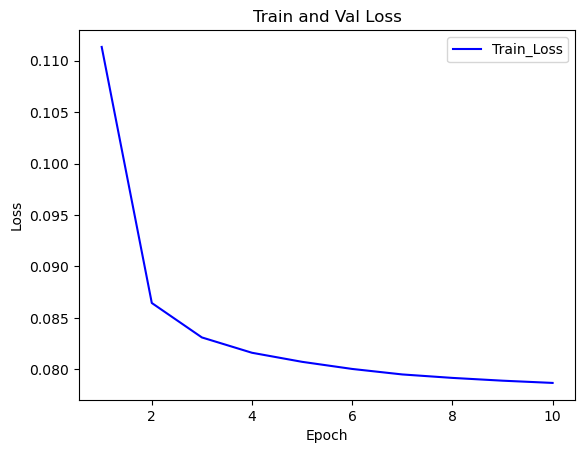

In [16]:
plt.figure()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue', linestyle="-", label='Train_Loss')
plt.legend()

plt.show()

## テストの実行

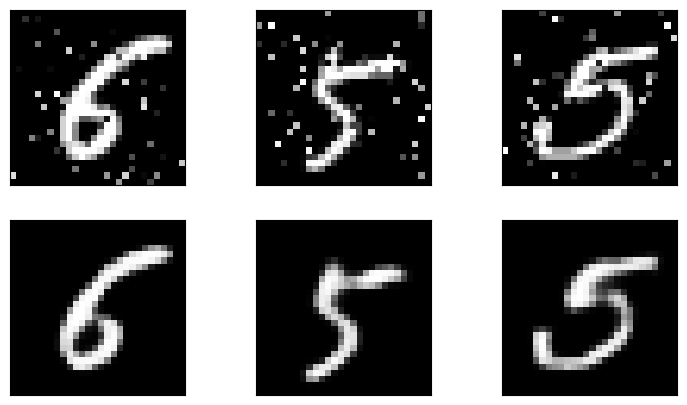

In [17]:
net.eval()

sample_num = 217
n_sample = 3

fig, axes = plt.subplots(nrows=2, ncols=n_sample, figsize=(n_sample * 3, 5))

for i, j in enumerate(range(sample_num, sample_num + n_sample)):
    input_tensor = test_x_noise[j: j+1]

    input_tensor = input_tensor.to(device)

    output_tensor = net(input_tensor)

    original_image = input_tensor.reshape(28, 28)
    original_image = original_image.cpu().numpy()

    output_image = output_tensor.reshape(28, 28)
    output_image = output_image.cpu().detach().numpy()

    ax_orig = axes[0, i]
    ax_orig.imshow(original_image, cmap='gray')
    ax_orig.set_xticks([])
    ax_orig.set_yticks([])

    ax_output = axes[1, i]
    ax_output.imshow(output_image, cmap='gray')
    ax_output.set_xticks([])
    ax_output.set_yticks([])

plt.show()

